# Implementation 1 - Long Short Term Memory Model to predict NVDA Stock price

For the task of predicting the stock price of NVDA, I chose the LSTM (Long Short-Term Memory) model, a specialized type of recurrent neural network (RNN). The primary reason for this choice is the inherent sequential nature of stock prices, where past prices and trends can influence future prices. LSTMs are adept at capturing and remembering long-term dependencies in time-series data, making them particularly well-suited for financial time-series forecasting. Additionally, stock prices often exhibit patterns over time, influenced by factors that might have occurred days, weeks, or even months ago. LSTMs, with their memory cells, can store and recall such long-term information, offering a potential advantage over traditional machine learning models. Moreover, NVDA, being a technology company with dynamic market interactions, may have complex underlying patterns in its stock movements. An LSTM's ability to model non-linear relationships and its flexibility to be incorporated with other architectures made it a compelling choice for this prediction task.

## Importing Python Libraries

In [ ]:
#Importing Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import itertools
import random
import os

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')


##Read in the NVDA Dataset

In [ ]:
data = pd.read_csv('LSTM_NVDA.csv')

##Exploratory Data Analysis on NVDA Dataset

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,48.945000,49.875000,48.625000,49.837502,49.317120,35561600
1,2018-01-03,51.025002,53.424999,50.937500,53.117500,52.562874,91470400
2,2018-01-04,53.939999,54.512501,53.172501,53.397499,52.839951,58326800
3,2018-01-05,53.547501,54.227501,52.770000,53.849998,53.287724,58012400
4,2018-01-08,55.099998,56.250000,54.645000,55.500000,54.920506,88121600


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1462 non-null   object 
 1   Open       1462 non-null   float64
 2   High       1462 non-null   float64
 3   Low        1462 non-null   float64
 4   Close      1462 non-null   float64
 5   Adj Close  1462 non-null   float64
 6   Volume     1462 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 80.1+ KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000,1.462000e+03
mean,147.495879,150.290764,144.633454,147.574196,147.300780,4.790244e+07
std,110.364030,112.373757,108.184420,110.315370,110.395653,2.172048e+07
min,31.622499,32.494999,31.115000,31.770000,31.526001,9.788400e+06
25%,59.536876,60.361874,58.595624,59.294999,59.004014,3.317760e+07
50%,129.932495,132.093750,127.652501,129.810005,129.516571,4.448535e+07
75%,199.831245,204.133129,196.898132,200.206875,199.888981,5.826578e+07
max,502.160004,502.660004,489.579987,493.549988,493.509338,2.511528e+08


In [ ]:
#only want the numbers for this dataset
data_prices = data.drop(['Date', 'Adj Close'], axis=1)
data_prices.columns = ['open', 'high', 'low', 'close', 'volume']
data_prices.head()

,open,high,low,close,volume
0,48.945000,49.875000,48.625000,49.837502,35561600
1,51.025002,53.424999,50.937500,53.117500,91470400
2,53.939999,54.512501,53.172501,53.397499,58326800
3,53.547501,54.227501,52.770000,53.849998,58012400
4,55.099998,56.250000,54.645000,55.500000,88121600


#Visualising the data we have

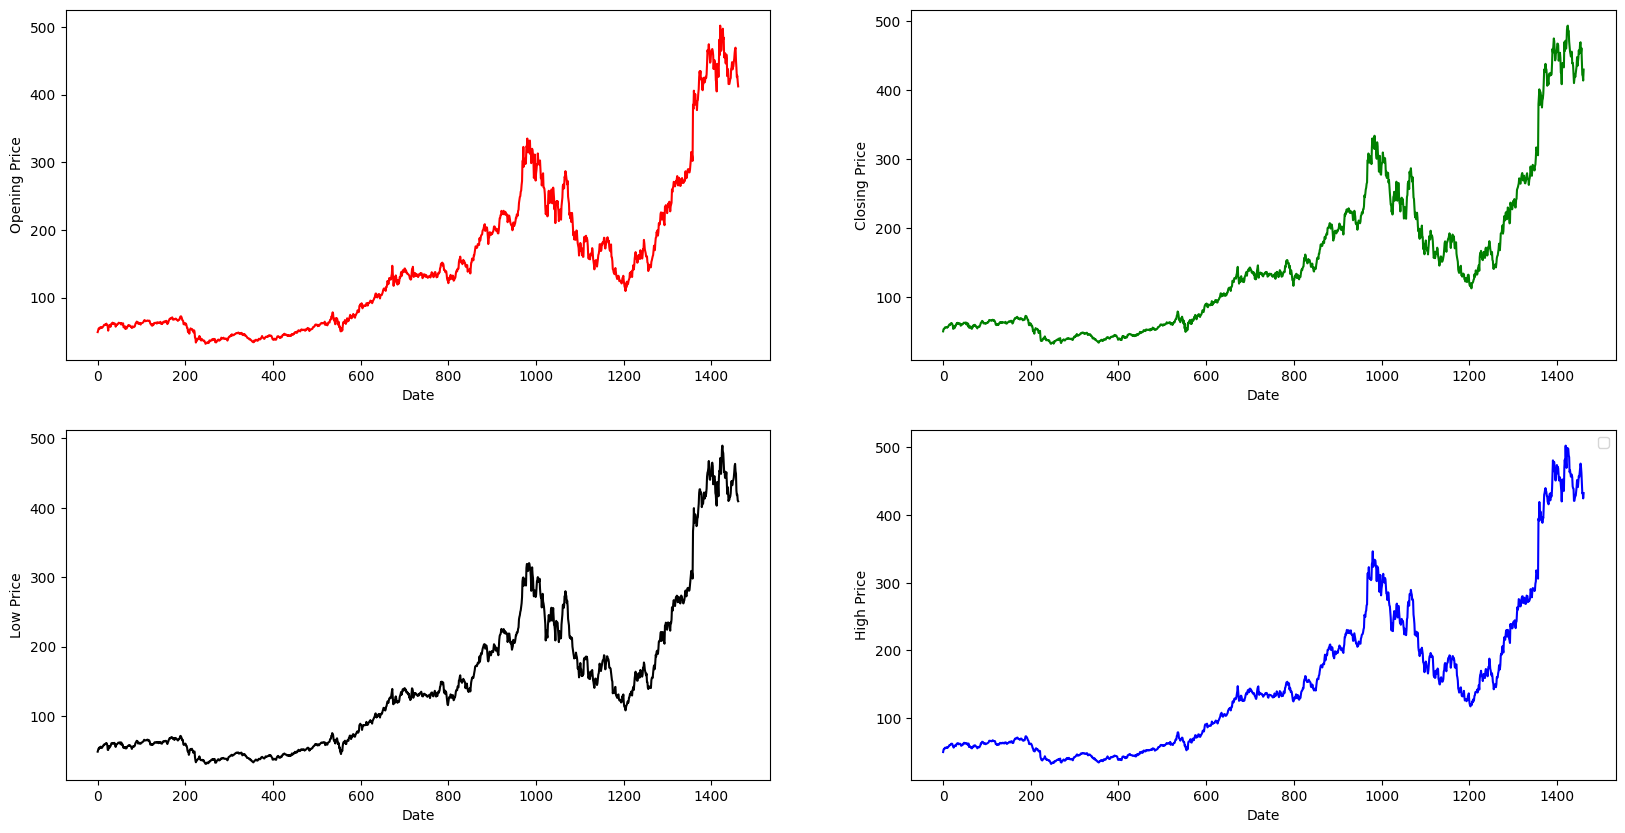

In [ ]:
#Visualising the price columns
plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.title = ('NVDA Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title = ('NVDA Closing Price')


ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.title = ('NVDA Low Price')


ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title = ('NVDA High Price')

plt.legend(loc='best')


##Feature Scaling

In [ ]:
#Choose close price and volums as 2 attributes to consider in our model
data_prices = data_prices.drop(['open', 'low', 'high'], axis=1)
data_prices.head()

,close,volume
0,49.837502,35561600
1,53.117500,91470400
2,53.397499,58326800
3,53.849998,58012400
4,55.500000,88121600


In [ ]:
data_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1462 non-null   float64
 1   volume  1462 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 23.0 KB


In [ ]:
#Normalise the data by scaling to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = scaler.fit_transform(data_prices)

In [ ]:
data_prices_scaled.shape


(1462, 2)

##Creating input data for LSTM model

In [ ]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [ ]:
# n_future = Number of days you want to predict into the future
# n_past = Number of past days you want to use to predict the future
X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,validation_split_percentage = 0)

In [ ]:
#Visualising test shapes
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1150, 25, 2)
(287, 25, 2)
(1150, 1)
(287, 1)


##Training the LSTM Model

In [ ]:
#Creating the LSTM Model
lstm_model = Sequential()

#Adding layers to the Sequemtial model
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=1, activation='linear'))
lstm_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#Getting a summary of the neural network
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 64)            17152     
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50241 (196.25 KB)
Trainable params: 50241 (196.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Implementing a manual Grid Search to tune the models hyperparameters.
#Usage of Early Stopping and Callback to reduce the hyperparameter tunning time

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#Fiting the model
history = lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
13/13 [==============================] - 13s 219ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 2/40
13/13 [==============================] - 1s 84ms/step - loss: 5.8934e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 3/40
13/13 [==============================] - 2s 134ms/step - loss: 3.3450e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 4/40
13/13 [==============================] - 1s 110ms/step - loss: 3.1858e-04 - root_mean_squared_error: 0.0178 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 5/40
13/13 [==============================] - 1s 115ms/step - loss: 2.7916e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 6/40
13/13 [==============================] - 1s 81ms/step - loss: 2.5466e-04 - root_mean_squared_error: 0.0160 - val_

In [ ]:
history.history.keys()


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

In [ ]:
#Obtaining results after tuning
results = lstm_model.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

9/9 [==============================] - 0s 10ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578
test loss, test acc: [0.0033 0.0578]


##Tuning hyperparameters in the LSTM Model

In [ ]:
#Implement manual gridsearch for tuning to find the best hyperparameters
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer,
                                                   second_additional_layer,
                                                   third_additional_layer,
                                                   n_neurons,
                                                   n_batch_size,
                                                   dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        lstm_model = Sequential()
        lstm_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        lstm_model.add(Dropout(dropout))

        if first_additional_layer:
            lstm_model.add(LSTM(units=n_neurons, return_sequences=True))
            lstm_model.add(Dropout(dropout))

        if second_additional_layer:
            lstm_model.add(LSTM(units=n_neurons, return_sequences=True))
            lstm_model.add(Dropout(dropout))

        if third_additional_layer:
            lstm_model.add(GRU(units=n_neurons, return_sequences=True))
            lstm_model.add(Dropout(dropout))

        lstm_model.add(LSTM(units=n_neurons, return_sequences=False))
        lstm_model.add(Dropout(dropout))
        lstm_model.add(Dense(units=1, activation='linear'))
        lstm_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        file_path = 'best_model.h5'
        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
        lstm_model.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


        train_accuracy = lstm_model.evaluate(x_train, y_train, verbose=0)
        test_accuracy = lstm_model.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist


In [ ]:
#Different configurations of neurons
config = [[False], [False], [False], [64, 128], [32, 64, 128], [0.2]]

In [ ]:
#Create list of performance of hyperparameters
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 64, 32, 0.2), (False, False, False, 64, 64, 0.2), (False, False, False, 64, 128, 0.2), (False, False, False, 128, 32, 0.2), (False, False, False, 128, 64, 0.2), (False, False, False, 128, 128, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00617, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00617 to 0.00177, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00177

Epoch 4: val_loss improved from 0.00177 to 0.00171, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00171

Epoch 6: val_loss did not improve from 0.00171

Epoch 7: val_loss improved from 0.00171 to 0.00159, saving model to best_model.h5

Epoch 8: val_loss improved from 0.00159 to 0.00158, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00158

Epoch 10: val_loss did not improve from 0.00158

Epoch 11: val_loss improved from 0.

##Choosing the best model

In [ ]:
#Visualise the performance of the different combinations
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
4,False,False,False,128,64,0.2,"[0.0003029594081453979, 0.017405729740858078]","[0.0024719967041164637, 0.049719177186489105]"
5,False,False,False,128,128,0.2,"[0.0004222931165713817, 0.020549772307276726]","[0.003549374407157302, 0.05957662686705589]"
2,False,False,False,64,128,0.2,"[0.0005209561786614358, 0.022824464365839958]","[0.00423474470153451, 0.06507491320371628]"
0,False,False,False,64,32,0.2,"[0.0003373754443600774, 0.01836778223514557]","[0.004689556080847979, 0.06848033517599106]"
3,False,False,False,128,32,0.2,"[0.00047233389341272414, 0.021733244881033897]","[0.005547491833567619, 0.07448148727416992]"
1,False,False,False,64,64,0.2,"[0.0004586485156323761, 0.021416081115603447]","[0.005992324557155371, 0.07741010934114456]"


##Results

In [ ]:
#Find the best possible combination of neurons and batch size.
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 128
 n_batch_size = 64
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0578

Results After Tunning:
 Test Set RMSE: 0.0497

14.0% Improvement


In [ ]:
#Set Optimal hyperparameters
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [ ]:
#Train and fit new LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(dropout))

if first_additional_layer:
    lstm_model.add(LSTM(units=n_neurons, return_sequences=True))
    lstm_model.add(Dropout(dropout))

if second_additional_layer:
    lstm_model.add(LSTM(units=n_neurons, return_sequences=True))
    lstm_model.add(Dropout(dropout))

if third_additional_layer:
    lstm_model.add(GRU(units=n_neurons, return_sequences=True))
    lstm_model.add(Dropout(dropout))

lstm_model.add(LSTM(units=n_neurons, return_sequences=False))
lstm_model.add(Dropout(dropout))
lstm_model.add(Dense(units=1, activation='linear'))
lstm_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.00905, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00905 to 0.00148, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00148

Epoch 4: val_loss improved from 0.00148 to 0.00140, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00140

Epoch 6: val_loss improved from 0.00140 to 0.00134, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00134

Epoch 8: val_loss improved from 0.00134 to 0.00128, saving model to best_model.h5

Epoch 9: val_loss improved from 0.00128 to 0.00127, saving model to best_model.h5

Epoch 10: val_loss did not improve from 0.00127

Epoch 11: val_loss improved from 0.00127 to 0.00122, saving model to best_model.h5

Epoch 12: val_loss improved from 0.00122 to 0.00119, saving model to best_model.h5

Epoch 13: val_loss improved from 0.00119 to 0.00117, saving model to best_model.h5

Epoch 14: val_loss improved from 0.00117 to 0.00115, saving 

In [ ]:
lstm_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 24ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658


[0.0043294732458889484, 0.06579872965812683]

##Visualise Predictions

9/9 [==============================] - 1s 22ms/step


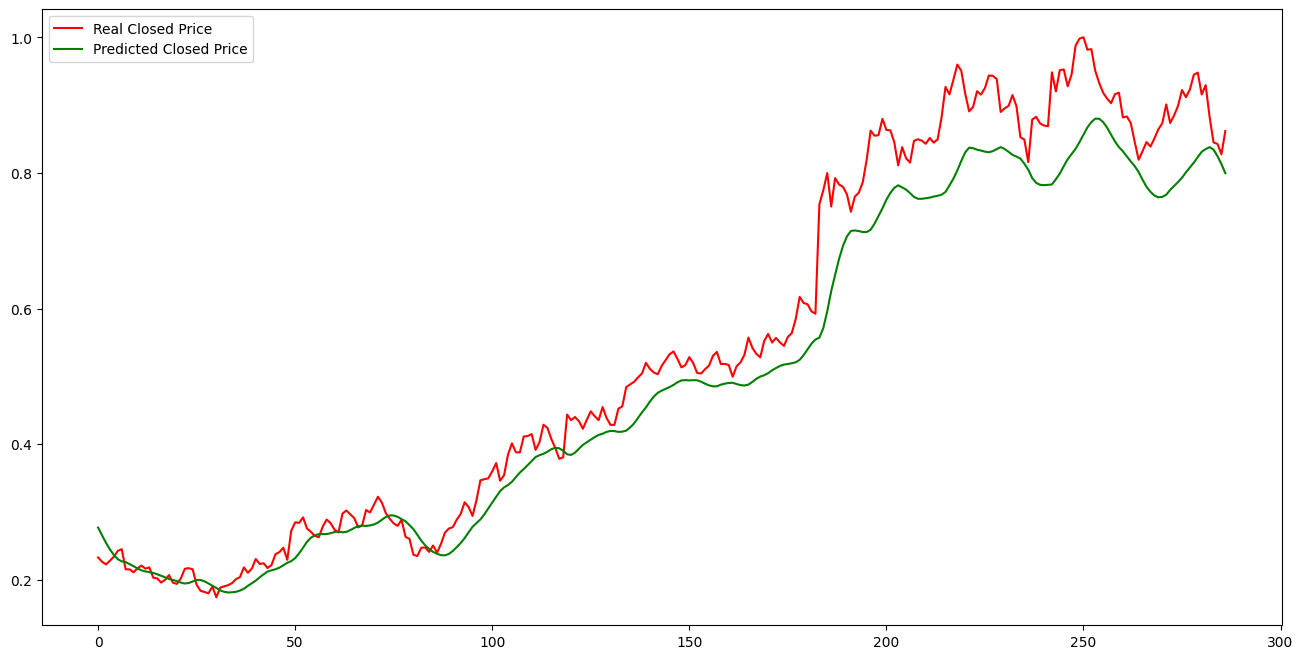

In [ ]:
y_pred = lstm_model.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Closed Price')
plt.plot(y_pred, color='green', label = 'Predicted Closed Price')
plt.legend(loc='best')

##Manipulating data to generate predictions

In [ ]:
#RMSE of the LSTM Model
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.06579872898371379


In [ ]:
# Number of days to predict
num_days = 10

# Use the last sequence from your test data as a starting point
current_batch = X_test[-1].reshape((1, X_test.shape[1], 2))

predicted_prices = []

for i in range(num_days):
    # Predict the next day's closing price
    predicted_value = lstm_model.predict(current_batch)[0][0]

    # Store the predicted price
    predicted_prices.append(predicted_value)

    # Construct the new input sequence by removing the oldest day and adding the predicted day
    new_input = np.array([[predicted_value, current_batch[0, -1, 1]]])

    # Update the current batch for the next iteration
    current_batch = np.append(current_batch[:, 1:, :], [new_input], axis=1)


1/1 [==============================] - 0s 31ms/step


In [ ]:
#Need to create dummy array as scaler object was used to scale the price_close column and volume column.

y_pred = np.array(predicted_prices).reshape(-1, 1)

dummy_data = np.zeros(y_pred.shape)

# Stack the predicted values and dummy data together.
inverse_data = np.hstack((y_pred, dummy_data))

# Now, inverse transform using the scaler.
inversed = scaler.inverse_transform(inverse_data)

# Extract the predicted prices.
predicted_prices_lstm = inversed[:, 0]

In [ ]:
predicted_prices_lstm

array([401.00985879, 393.74497534, 385.97846275, 378.03037281,
       370.10300861, 362.31791717, 354.75172594, 347.44299639,
       340.40185741, 333.6347497 ])

##Generating predictions for the next 10 days

In [ ]:
# Convert the array to a dataframe
df_predicted = pd.DataFrame(predicted_prices_lstm, columns=['Close'])

In [ ]:
df_predicted

,Close
0,401.009859
1,393.744975
2,385.978463
3,378.030373
4,370.103009
5,362.317917
6,354.751726
7,347.442996
8,340.401857
9,333.634750


##Exporting the predictions

In [ ]:
df_predicted.to_csv('Jerry_Yang_implementation1.csv')